# 7. Validation Sets, Early Stopping and Saver-Loader methods

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (15/06/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- OS (part of the Python library)
- Pickle (part of the Python library)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
from numpy.random import default_rng
# OS
import os
# Pickle
import pickle
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock dataset, with nonlinearity

As in the previous notebook, we will reuse our nonlinear binary classification mock dataset and generate 1000 samples.

In [2]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
n_points = 1000
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(47)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
print(inputs.shape)
print(outputs.shape)

(1000, 2)
(1000, 1)


As expected and observed in the plots below, the dataset now longer exhibits linearity. In fact the function is no longer polynomial either due to the presence of a logarithmic function.

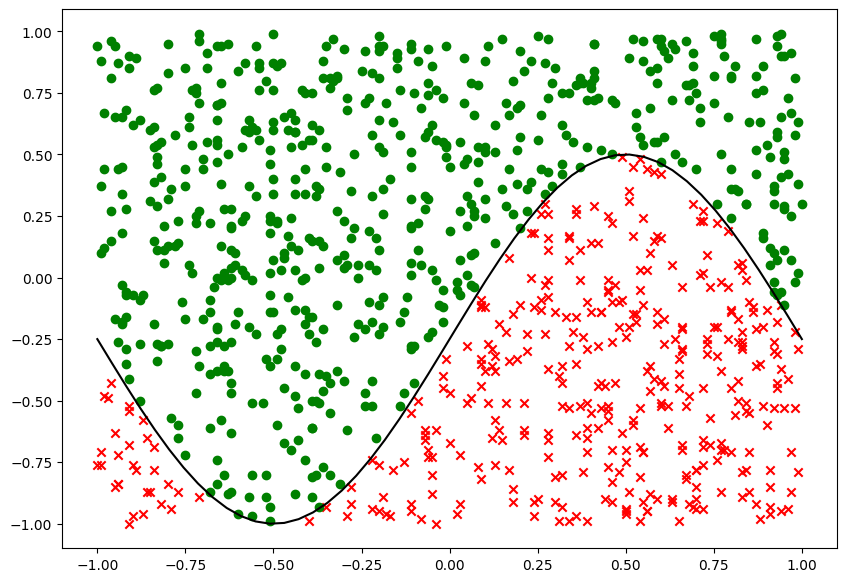

In [4]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.show()

### Our previous Shallow Neural Net class, with accuracies and an early stop on accuracies

We wil reuse our previous class from NB6, which implements a Stochastic Mini-Batch GD, with Adam.

In this section, we add a method, **accuracy()**, which calculates the model accuracy for a given set of inputs and outputs. The model typically formulates predictions on the given inputs, and compares them to the ground truth contained in the outputs.

This is implemented in the method below.

```
def accuracy(self, inputs, outputs):
    # Calculate accuracy for given inputs and ouputs
    pred = [int(val >= 0.5) for val in self.forward(inputs)]
    acc = sum([int(val1 == val2[0]) for val1, val2 in zip(pred, outputs)])/outputs.shape[0]
    return acc
```

Our **train()** method has then been reworked and will now compute not just the losses, but the accuracies of the model as well, when it attempts to predict on the entire dataset.

```
# Update loss attribute on all losses
self.loss = self.CE_loss(inputs, outputs)
# Update losses list
self.losses_list.append(self.loss)

# Update accuracies
acc = self.accuracy(inputs, outputs)
self.accuracies_list.append(acc)
```

It will also store them in lists attributes for later display

```
# List of losses, starts with the current loss
self.losses_list = [self.CE_loss(inputs, outputs)]
self.accuracies_list = [self.accuracy(inputs, outputs)]
```

It will also display at regular interval the values of the losses and accuracies during training.

```
# Display
if(display and iteration_number % (N_max*0.05) == 1):
    print("Iteration {} - Loss = {} - Acc = {}".format(iteration_number, self.loss, acc))

```

Our training will stop early, if the accuracy is not improving and it already has 98% accuracy.

```
if(difference < delta and self.accuracies_list[-1] > 0.98):
    if(display):
        message = "Stopping early - accuracy evolution was less than delta on"
        message += "iteration {}.".format(iteration_number)
        print(message)
        break
```

Finally, we have reworked and renamed our training curves display method, so that it displays losses and accuracies over time.

```
def show_training_curves(self):
    # Initialize matplotlib
    fig, axs = plt.subplots(1, 3, figsize = (15, 7))
    axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
    axs[0].set_xlabel("Iteration number")
    axs[0].set_ylabel("Loss")
    axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
    axs[1].set_xlabel("Iteration number")
    axs[1].set_ylabel("Loss (in logarithmic scale)")
    axs[1].set_yscale("log")
    axs[2].plot(list(range(len(self.accuracies_list))), self.accuracies_list)
    axs[2].set_xlabel("Iteration number")
    axs[2].set_ylabel("Accuracy")
    # Display
    plt.show()
```

In [5]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def accuracy(self, inputs, outputs):
        # Calculate accuracy for given inputs and ouputs
        pred = [int(val >= 0.5) for val in self.forward(inputs)]
        acc = sum([int(val1 == val2[0]) for val1, val2 in zip(pred, outputs)])/outputs.shape[0]
        return acc
    
    def backward(self, inputs, outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        dL_dZ2 = dL_dA2*A2*(1 - A2)
        dL_dA1 = np.dot(dL_dZ2, self.W2.T)
        dL_dZ1 = dL_dA1*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = (-1/m)*np.dot(A1.T, dL_dZ2)
        grad_W1 = (-1/m)*np.dot(inputs.T, dL_dZ1)
        grad_b2 = (-1/m)*np.sum(dL_dZ2, axis = 0, keepdims = True)
        grad_b1 = (-1/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
              delta = 1e-5, batch_size = 100, display = True):
        # Get number of samples
        M = inputs.shape[0]
        
        # List of losses, starts with the current loss
        self.losses_list = [self.CE_loss(inputs, outputs)]
        self.accuracies_list = [self.accuracy(inputs, outputs)]
        
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Define RNG for stochastic minibatches
        rng = default_rng()
        
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Select a subset of inputs and outputs with given batch size
            shuffler = rng.choice(M, size = batch_size, replace = False)
            inputs_sub = inputs[shuffler, :]
            outputs_sub = outputs[shuffler, :]
            
            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
                
            # Update loss attribute on all losses
            self.loss = self.CE_loss(inputs, outputs)
            # Update losses list
            self.losses_list.append(self.loss)
            
            # Update accuracies
            acc = self.accuracy(inputs, outputs)
            self.accuracies_list.append(acc)
            
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {} - Acc = {}".format(iteration_number, self.loss, acc))
            # Check for delta value and early stop criterion
            difference = abs(self.accuracies_list[-1] - self.accuracies_list[-2])
            if(difference < delta and self.accuracies_list[-1] > 0.98):
                if(display):
                    message = "Stopping early - accuracy evolution was less than delta on"
                    message += "iteration {}.".format(iteration_number)
                    print(message)
                    break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_training_curves(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 3, figsize = (15, 7))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        axs[2].plot(list(range(len(self.accuracies_list))), self.accuracies_list)
        axs[2].set_xlabel("Iteration number")
        axs[2].set_ylabel("Accuracy")
        # Display
        plt.show()

If you allow the model to train, you will most likely realize that the accuracy reaches 100% (or close to 100% after a few iterations). The loss however requires a few more iterations to converge. 

This raises a few questions:
- Should we have stopped when the accuracy was already 100%?
- Are we overfitting by pursuing the training in an attempt to minimize the loss even more, even though it will not improve the accuracy further?

In [6]:
# Define and train neural network structure (stochastic minibatch GD)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_stominibatch = ShallowNeuralNet(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_stominibatch.train(inputs, outputs, N_max = 500, alpha = 1e-1, beta1 = 0.9, \
                                      beta2 = 0.999, delta = 1e-4, batch_size = 128, display = True)
print(shallow_neural_net_stominibatch.loss)

Iteration 1 - Loss = 0.6562195160469543 - Acc = 0.626
Iteration 26 - Loss = 0.27915458530198645 - Acc = 0.864
Iteration 51 - Loss = 0.27638776890012867 - Acc = 0.872
Iteration 76 - Loss = 0.26694423115062615 - Acc = 0.869
Iteration 101 - Loss = 0.23525660780221685 - Acc = 0.882
Iteration 126 - Loss = 0.20422858141105332 - Acc = 0.898
Iteration 151 - Loss = 0.1776151149825131 - Acc = 0.923
Iteration 176 - Loss = 0.1563196145969894 - Acc = 0.926
Iteration 201 - Loss = 0.14327954281233365 - Acc = 0.934
Iteration 226 - Loss = 0.1289648853732909 - Acc = 0.946
Iteration 251 - Loss = 0.11689577415624948 - Acc = 0.948
Iteration 276 - Loss = 0.11280994578395598 - Acc = 0.948
Iteration 301 - Loss = 0.10260052096226122 - Acc = 0.956
Iteration 326 - Loss = 0.09542909942345092 - Acc = 0.959
Iteration 351 - Loss = 0.08936215267384631 - Acc = 0.954
Iteration 376 - Loss = 0.08137015346429086 - Acc = 0.976
Stopping early - accuracy evolution was less than delta oniteration 382.
0.08073505127655252


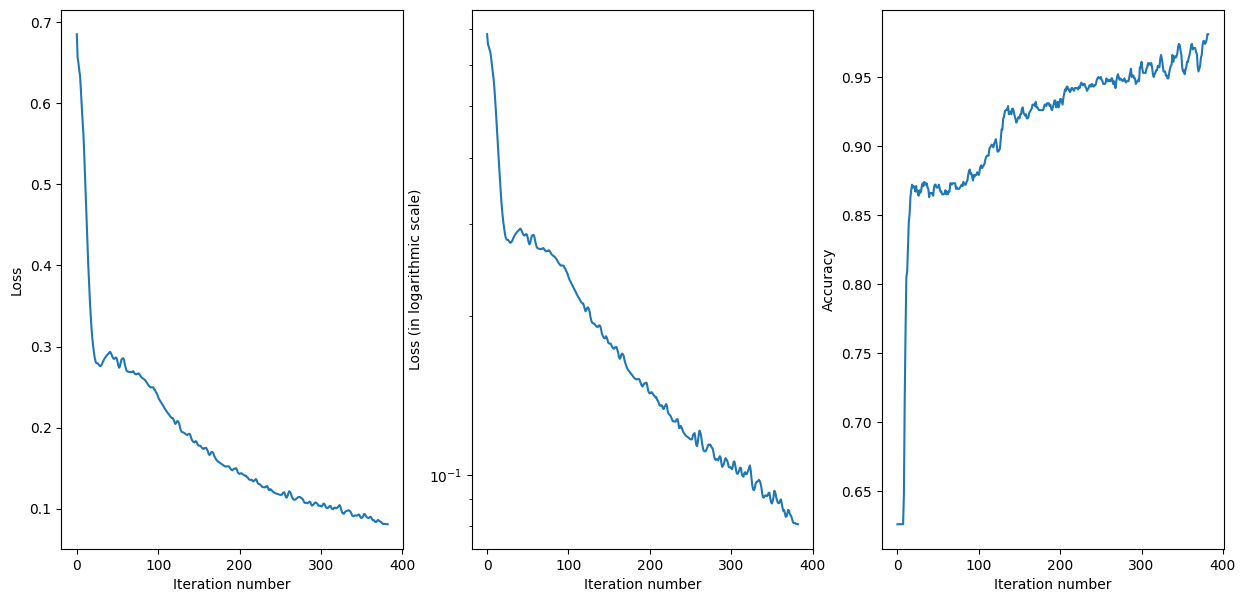

In [7]:
shallow_neural_net_stominibatch.show_training_curves()

### Train, test and validation sets

In order to answer, these two questions, recall how we checked for underfitting and overfitting in W1-Notebook 4. 

In this notebook, we introduced the concept of generalization and discussed how it is common practice not to evaluate the performance of the model on the same samples that have been used for training. This led us to define two sets of samples, called train and test, and we would:
- use the train samples in the backpropagation/training procedure,
- and use the test samples to evaluate the model and assess if it is able to generalize well or not.

We will push it one step further, by introducing the concept of **train, test and validation samples**.

The training set is used to train a machine learning model. The model is presented with many examples from the training set, and the model "learns" to make predictions based on those examples.

The validation set is used to evaluate the performance of the model during the training process. After training the model on the training set, the model is tested on the validation set to see how well it generalizes to unseen data. The validation set helps to tune the hyperparameters of the model, which are the parameters that are not learned from the data but are set prior to training.

The test set is used to evaluate the final performance of the model after training is complete. The test set is a completely separate set of data that the model has not seen during the training or validation process. The performance of the model on the test set provides an estimate of how well the model will perform on unseen data in the future.

It is important to split a dataset into these three sets to avoid overfitting, which is when a model performs well on the training data but poorly on new, unseen data. By using a separate validation set to tune the model and a separate test set to evaluate the final model, it is possible to get a more accurate estimate of the model's performance on new, unseen data.

We will then use the code below to generate a training set with 1000 samples, a test set with 100 samples and a validation set with 100 samples.

In [8]:
# Generate dataset (train)
np.random.seed(47)
n_points_train = 1000
train_val1_list, train_val2_list, train_inputs, train_outputs = create_dataset(n_points_train, min_val, max_val)
print(train_inputs.shape)
print(train_outputs.shape)

(1000, 2)
(1000, 1)


In [9]:
# Generate dataset (test)
np.random.seed(17)
n_points_test = 100
test_val1_list, test_val2_list, test_inputs, test_outputs = create_dataset(n_points_test, min_val, max_val)
print(test_inputs.shape)
print(test_outputs.shape)

(100, 2)
(100, 1)


In [10]:
# Generate dataset (valid)
np.random.seed(27)
n_points_valid = 100
valid_val1_list, valid_val2_list, valid_inputs, valid_outputs = create_dataset(n_points_valid, min_val, max_val)
# Check a few entries of the dataset
print(valid_inputs.shape)
print(valid_outputs.shape)

(100, 2)
(100, 1)


As expected and observed in the plots below, the dataset now longer exhibits linearity.

In fact the function is no longer polynomial either due to the presence of a sine function.

We can produce three displays for the training, test and validation sets.

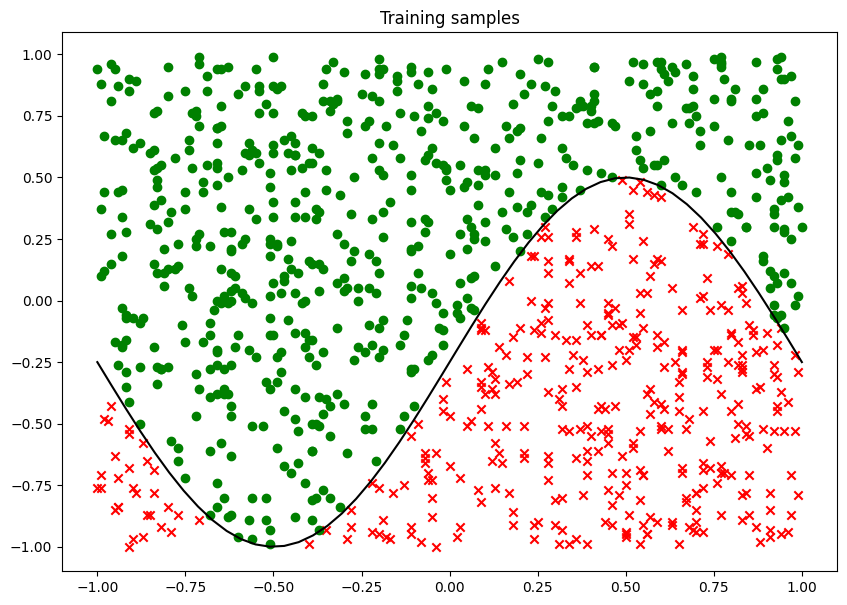

In [11]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(train_outputs == 0)[0]
v1_0 = train_val1_list[indexes_0]
v2_0 = train_val2_list[indexes_0]
indexes_1 = np.where(train_outputs == 1)[0]
v1_1 = train_val1_list[indexes_1]
v2_1 = train_val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.title("Training samples")
plt.show()

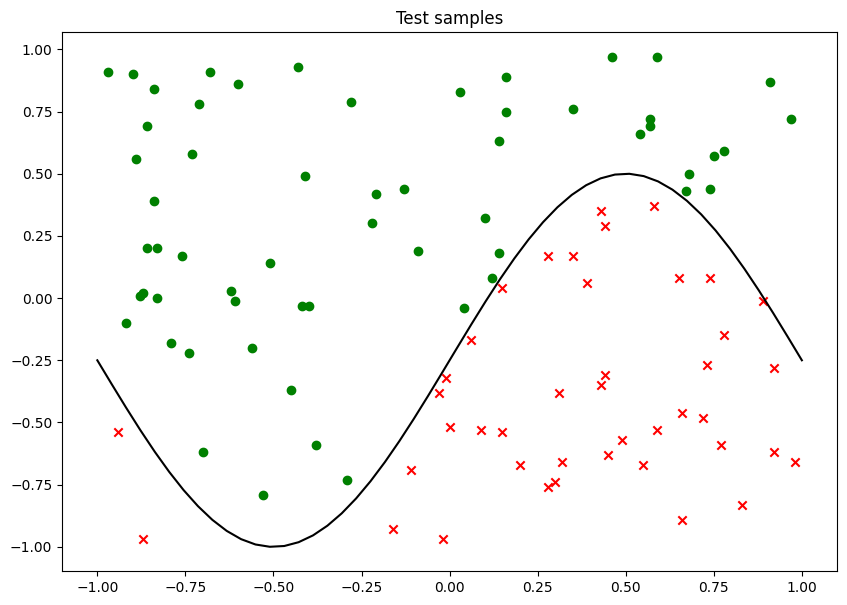

In [12]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(test_outputs == 0)[0]
v1_0 = test_val1_list[indexes_0]
v2_0 = test_val2_list[indexes_0]
indexes_1 = np.where(test_outputs == 1)[0]
v1_1 = test_val1_list[indexes_1]
v2_1 = test_val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.title("Test samples")
plt.show()

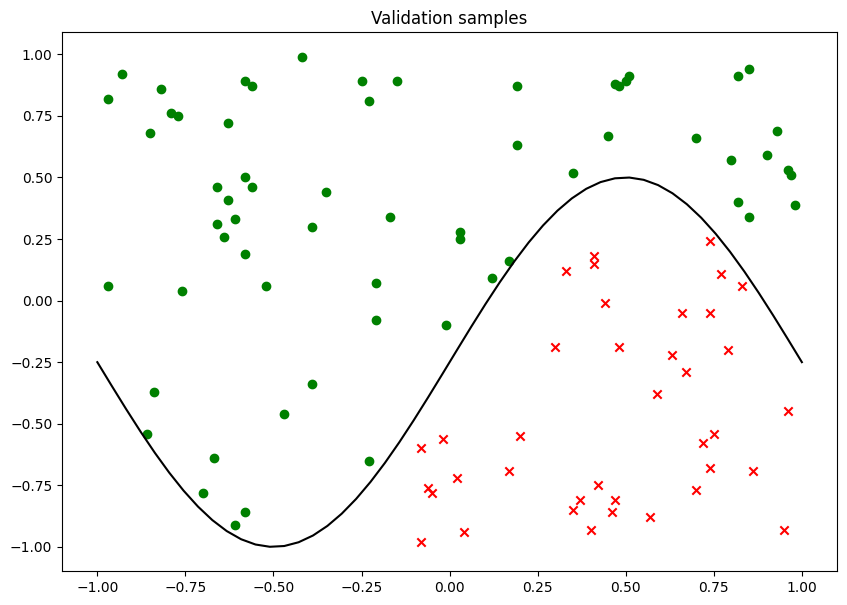

In [13]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(valid_outputs == 0)[0]
v1_0 = valid_val1_list[indexes_0]
v2_0 = valid_val2_list[indexes_0]
indexes_1 = np.where(valid_outputs == 1)[0]
v1_1 = valid_val1_list[indexes_1]
v2_1 = valid_val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.title("Validation samples")
plt.show()

### Our previous Shallow Neural Net class, with train, test and validation sets

We will reuse and amend our previous SNN class, and rename it as **ShallowNeuralNet_TTVsets**.

The first change has to do with the train method, which now uses train, test and validation inputs and outputs.
```
def train(self, train_inputs, train_outputs, test_inputs, test_outputs, valid_inputs, valid_outputs, \
          N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
          delta = 1e-5, batch_size = 100, display = True):
```

It then includes four list attributes to keep track ot the train/validation losses and accuracies.

```
# List of losses and accuracies
self.train_losses_list = [self.CE_loss(train_inputs, train_outputs)]
self.train_accuracies_list = [self.accuracy(train_inputs, train_outputs)]
self.valid_losses_list = [self.CE_loss(valid_inputs, valid_outputs)]
self.valid_accuracies_list = [self.accuracy(valid_inputs, valid_outputs)]
```

At regular intervals during training we will calculate and track the losses and accuracies on both the train and validation sets. They will aslo be printed on screen for training control.

```
# Update losses list
train_loss = self.CE_loss(train_inputs, train_outputs)
self.train_losses_list.append(train_loss)
valid_loss = self.CE_loss(valid_inputs, valid_outputs)
self.valid_losses_list.append(valid_loss)

# Update accuracies
train_acc = self.accuracy(train_inputs, train_outputs)
self.train_accuracies_list.append(train_acc)
valid_acc = self.accuracy(valid_inputs, valid_outputs)
self.valid_accuracies_list.append(valid_acc)

# Display
message = "Iteration {} ".format(iteration_number)
message += "\n - Train Loss = {} - Train Acc = {}".format(train_loss, train_acc)
message += "\n - Validation Loss = {} - Validation Acc = {}".format(valid_loss, valid_acc)
print(message)
```

Finally, after the training procedure is complete, we will compute the accuracy on the test samples, using:

```
# Display Accuracy on validation
print("Test accuracy = {}".format(self.accuracy(test_inputs, test_outputs)))
```

The training curves display method has also been amended to include the train and validation curves.

```
def show_training_curves(self):
    # Initialize matplotlib
    fig, axs = plt.subplots(1, 3, figsize = (15, 7))
    axs[0].plot(list(range(len(self.train_losses_list))), \
                self.train_losses_list, "b--", \
                label = "Train loss")
    axs[0].plot(list(range(len(self.valid_losses_list))), \
                self.valid_losses_list, "r--", \
                label = "Valid loss")
    axs[0].set_xlabel("Iteration number")
    axs[0].set_ylabel("Losses")
    axs[1].plot(list(range(len(self.train_losses_list))), \
                self.train_losses_list, "b--", \
                label = "Train loss")
    axs[1].plot(list(range(len(self.valid_losses_list))), \
                self.valid_losses_list, "r--", \
                label = "Valid loss")
    axs[1].set_xlabel("Iteration number")
    axs[1].set_ylabel("Losses (in logarithmic scale)")
    axs[1].set_yscale("log")
    axs[2].plot(list(range(len(self.train_accuracies_list))), \
                self.train_accuracies_list, "b--", \
                label = "Train Acc")
    axs[2].plot(list(range(len(self.valid_accuracies_list))), \
                self.valid_accuracies_list, "r--", \
                label = "Valid Acc")
    axs[2].set_xlabel("Iteration number")
    axs[2].set_ylabel("Accuracies")
    # Display
    axs[0].legend(loc = "best")
    axs[1].legend(loc = "best")
    axs[2].legend(loc = "best")
    plt.show()
```

Do note that we have also commented the early stoping block, to let the training go through all specified iterations on purpose.

```
"""
# Check for delta value and early stop criterion
difference = abs(self.valid_accuracies_list[-1] - self.valid_accuracies_list[-2])
if(difference < delta and self.valid_accuracies_list[-1] > 0.98):
    if(display):
        message = "Stopping early - accuracy evolution was less than delta on"
        message += "iteration {}.".format(iteration_number)
        print(message)
        break
"""
```

In [32]:
class ShallowNeuralNet_TTVsets():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def accuracy(self, inputs, outputs):
        # Calculate accuracy for given inputs and ouputs
        pred = [int(val >= 0.5) for val in self.forward(inputs)]
        acc = sum([int(val1 == val2[0]) for val1, val2 in zip(pred, outputs)])/outputs.shape[0]
        return acc
    
    def backward(self, train_inputs, train_outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        dL_dZ2 = dL_dA2*A2*(1 - A2)
        dL_dA1 = np.dot(dL_dZ2, self.W2.T)
        dL_dZ1 = dL_dA1*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = (-1/m)*np.dot(A1.T, dL_dZ2)
        grad_W1 = (-1/m)*np.dot(inputs.T, dL_dZ1)
        grad_b2 = (-1/m)*np.sum(dL_dZ2, axis = 0, keepdims = True)
        grad_b1 = (-1/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, train_inputs, train_outputs, test_inputs, test_outputs, valid_inputs, valid_outputs, \
              N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
              delta = 1e-5, batch_size = 100, display = True):
        # Get number of samples
        M = inputs.shape[0]
        
        # List of losses and accuracies
        self.train_losses_list = [self.CE_loss(train_inputs, train_outputs)]
        self.train_accuracies_list = [self.accuracy(train_inputs, train_outputs)]
        self.valid_losses_list = [self.CE_loss(valid_inputs, valid_outputs)]
        self.valid_accuracies_list = [self.accuracy(valid_inputs, valid_outputs)]
        
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Define RNG for stochastic minibatches
        rng = default_rng()
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Select a subset of inputs and outputs with given batch size
            shuffler = rng.choice(M, size = batch_size, replace = False)
            inputs_sub = train_inputs[shuffler, :]
            outputs_sub = train_outputs[shuffler, :]
            
            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
            
            if(iteration_number % (N_max*0.1) == 1):
                # Update losses list
                train_loss = self.CE_loss(train_inputs, train_outputs)
                self.train_losses_list.append(train_loss)
                valid_loss = self.CE_loss(valid_inputs, valid_outputs)
                self.valid_losses_list.append(valid_loss)

                # Update accuracies
                train_acc = self.accuracy(train_inputs, train_outputs)
                self.train_accuracies_list.append(train_acc)
                valid_acc = self.accuracy(valid_inputs, valid_outputs)
                self.valid_accuracies_list.append(valid_acc)
                
                # Display
                if (display):
                    message = "Iteration {} ".format(iteration_number)
                    message += "\n - Train Loss = {} - Train Acc = {}".format(train_loss, train_acc)
                    message += "\n - Validation Loss = {} - Validation Acc = {}".format(valid_loss, valid_acc)
                    print(message)
            
            """
            # Check for delta value and early stop criterion
            difference = abs(self.valid_accuracies_list[-1] - self.valid_accuracies_list[-2])
            if(difference < delta and self.valid_accuracies_list[-1] > 0.98):
                if(display):
                    message = "Stopping early - obtained good daccuracy (at least 98%)"
                    message += " and accuracy evolution was less than delta on"
                    message += "iteration {}.".format(iteration_number)
                    print(message)
                    break
            """
            
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
                
        # Display Accuracy on test
        print("Test accuracy = {}".format(self.accuracy(test_inputs, test_outputs)))
    
    def show_training_curves(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 3, figsize = (15, 7))
        axs[0].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[0].plot(list(range(len(self.valid_losses_list))), \
                    self.valid_losses_list, "r--", \
                    label = "Valid loss")
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Losses")
        axs[1].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[1].plot(list(range(len(self.valid_losses_list))), \
                    self.valid_losses_list, "r--", \
                    label = "Valid loss")
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Losses (in logarithmic scale)")
        axs[1].set_yscale("log")
        axs[2].plot(list(range(len(self.train_accuracies_list))), \
                    self.train_accuracies_list, "b--", \
                    label = "Train Acc")
        axs[2].plot(list(range(len(self.valid_accuracies_list))), \
                    self.valid_accuracies_list, "r--", \
                    label = "Valid Acc")
        axs[2].set_xlabel("Iteration number")
        axs[2].set_ylabel("Accuracies")
        # Display
        axs[0].legend(loc = "best")
        axs[1].legend(loc = "best")
        axs[2].legend(loc = "best")
        plt.show()

The model trains, and the train/validations accuracies and losses seem to have pretty close values.

This is the sign that the model is training well, in the sense that it will be able to generalize well.

This is later confirmed by the test accuracy, being calculated once the training is complete.

In [33]:
# Define and train neural network structure (TTV sets)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_ttv = ShallowNeuralNet_TTVsets(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_ttv.train(train_inputs, train_outputs, test_inputs, test_outputs, \
                             valid_inputs, valid_outputs, N_max = 300, alpha = 1e-1, \
                             beta1 = 0.9, beta2 = 0.999, delta = 1e-4, batch_size = 128, display = True)

Iteration 1 
 - Train Loss = 0.6562206116565713 - Train Acc = 0.626
 - Validation Loss = 0.6592760519158617 - Validation Acc = 0.62
Iteration 31 
 - Train Loss = 0.2830951890174539 - Train Acc = 0.869
 - Validation Loss = 0.20063836446117492 - Validation Acc = 0.91
Iteration 61 
 - Train Loss = 0.2656823064976081 - Train Acc = 0.876
 - Validation Loss = 0.19536548122888026 - Validation Acc = 0.91
Iteration 91 
 - Train Loss = 0.2051948666756941 - Train Acc = 0.91
 - Validation Loss = 0.12551601511035104 - Validation Acc = 0.98
Iteration 121 
 - Train Loss = 0.15131533920216939 - Train Acc = 0.934
 - Validation Loss = 0.10093479006170472 - Validation Acc = 0.99
Iteration 151 
 - Train Loss = 0.1115951833149475 - Train Acc = 0.955
 - Validation Loss = 0.07298127188796165 - Validation Acc = 0.99
Iteration 181 
 - Train Loss = 0.07802364083046055 - Train Acc = 0.98
 - Validation Loss = 0.05391519243728255 - Validation Acc = 1.0
Iteration 211 
 - Train Loss = 0.05500636101156745 - Train Acc

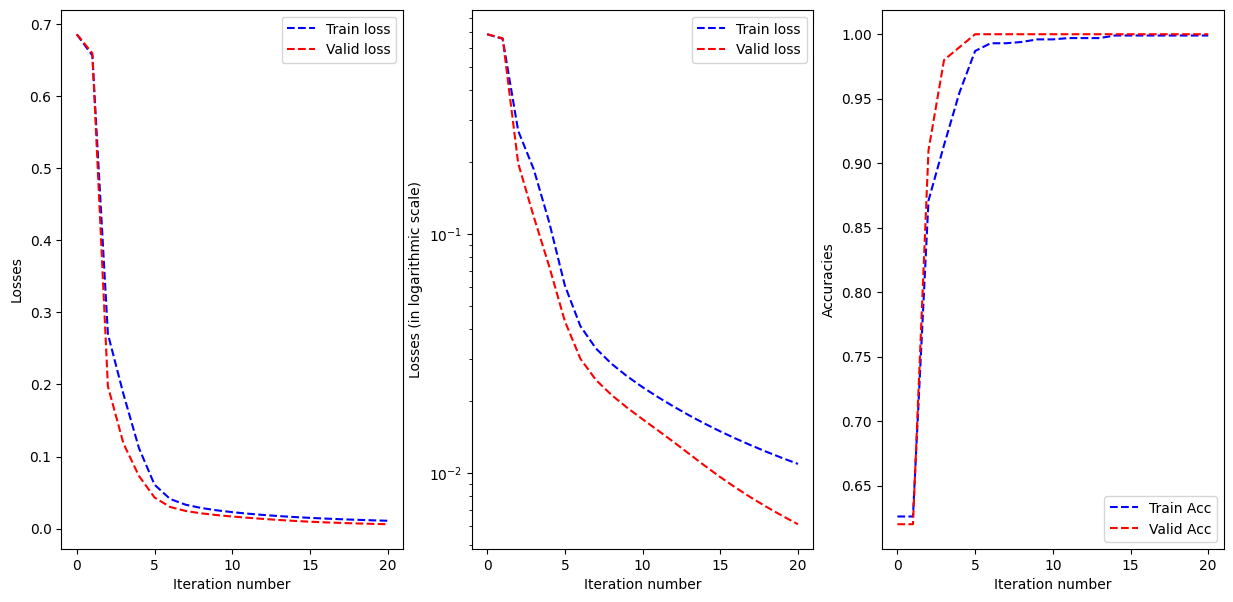

In [16]:
shallow_neural_net_ttv.show_training_curves()

A gap might appear between the train and validation values. This is often the sign that something went wrong with the training and that we might be overfitting or underfitting.

Below, we are clearly underfitting, because we only allowed the model to train for a very small number of iterations. Its training was not yet complete and it was therefore underfitting.

In [29]:
# Define and train neural network structure (TTV sets)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_ttv2 = ShallowNeuralNet_TTVsets(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_ttv2.train(train_inputs, train_outputs, test_inputs, test_outputs, \
                             valid_inputs, valid_outputs, N_max = 40, alpha = 1e-1, \
                             beta1 = 0.9, beta2 = 0.999, delta = 1e-4, batch_size = 128, display = True)

Iteration 1 
 - Train Loss = 0.6562206116565713 - Train Acc = 0.626
 - Validation Loss = 0.6592760519158617 - Validation Acc = 0.62
Iteration 3 
 - Train Loss = 0.644088702428045 - Train Acc = 0.626
 - Validation Loss = 0.6448520525118495 - Validation Acc = 0.62
Iteration 5 
 - Train Loss = 0.6122340762176314 - Train Acc = 0.626
 - Validation Loss = 0.6085726358789545 - Validation Acc = 0.62
Iteration 7 
 - Train Loss = 0.5810911378934485 - Train Acc = 0.633
 - Validation Loss = 0.5727682964203877 - Validation Acc = 0.63
Iteration 9 
 - Train Loss = 0.5275314370773658 - Train Acc = 0.705
 - Validation Loss = 0.512434298523494 - Validation Acc = 0.73
Iteration 11 
 - Train Loss = 0.46935756648504606 - Train Acc = 0.774
 - Validation Loss = 0.44517568324250006 - Validation Acc = 0.78
Iteration 13 
 - Train Loss = 0.41181243629443004 - Train Acc = 0.834
 - Validation Loss = 0.378270044155486 - Validation Acc = 0.9
Iteration 15 
 - Train Loss = 0.36072361434855166 - Train Acc = 0.872
 - Va

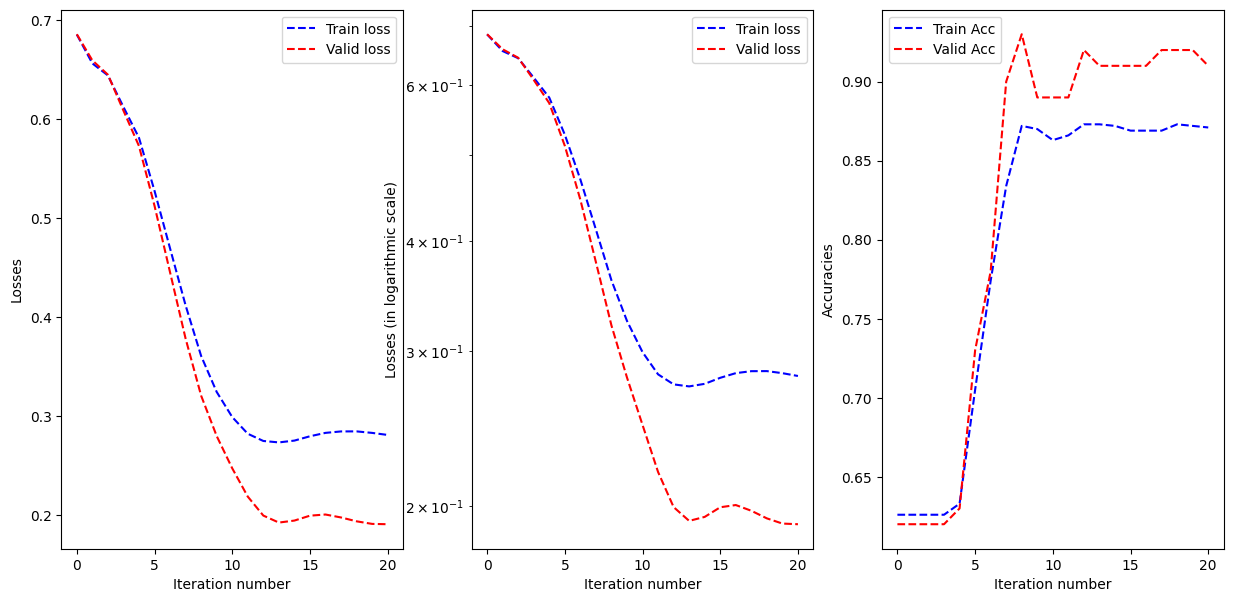

In [30]:
shallow_neural_net_ttv2.show_training_curves()

### Visualization

As before, we can confirm the fitting by displaying the decision boundary for both models above.

In [19]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        out = model.forward([v1, v2_avg])
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

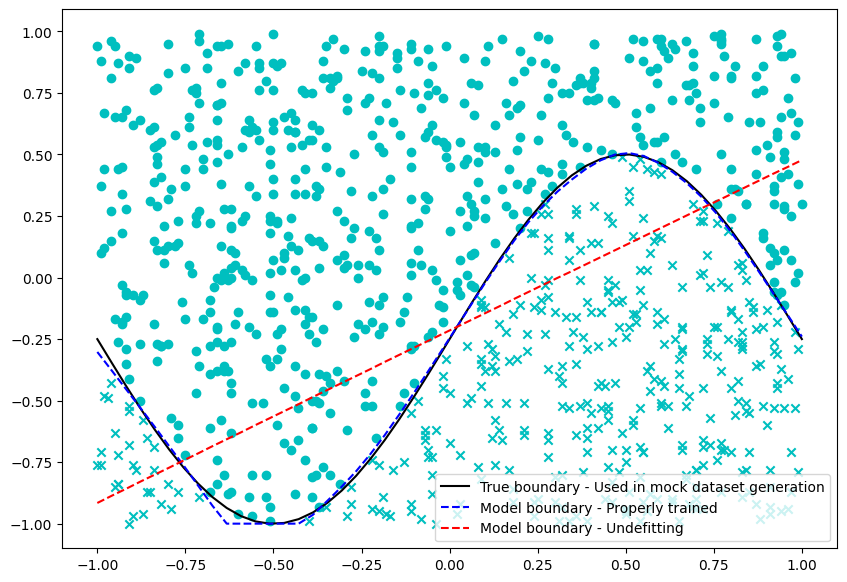

In [20]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (properly trained)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_batch = [find_v2(v1, shallow_neural_net_ttv, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_batch, "b--", label = "Model boundary - Properly trained")

# Display model boundary (properly trained)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_batch = [find_v2(v1, shallow_neural_net_ttv2, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_batch, "r--", label = "Model boundary - Undefitting")

# Show
plt.legend(loc = "best")
plt.show()

### Saver and loader functions

As before, we might decide to implement an early stopping condition, which will interrupt the training before the model overfits. This is something we have investigated in previous notebooks and that we leave for implementation as extra practice.

Another very common approach consists of regularly saving the model parameters to a file. To do so, we will implement two additional methods, **save()** and **load()**, which save (resp. load) the model parameters to (resp. from) a file.

This will be simply implemented using pickle, a default Python library, and will be added to our SNN class, which we will rename as **ShallowNeuralNet_save**.

We will then save our model at regular intervals during training, by using:

```
# Save model
self.save("./save", iter_num = str(iteration_number))
```
We will aslo save the model at the end of training, using:
```
# Save final model
self.save("./save")
```

Saving the model at regular intervals like this, is considered good practice for many reasons:

1. **Preventing data loss:** Training a model can take a long time, sometimes even days or weeks if the architecture is massive. If the training process is interrupted (e.g. due to a power outage), all the progress made so far will be lost unless the model has been saved. In case of an interruption, we can then load the latest save of the model and resume the training from that point onwards, instead of re-initializing all the parameters randomly and restarting the training from scratch.

2. **Evaluating model performance:** Saving the model at regular intervals during training allows you to evaluate the model's performance on a validation set at various stages of training. This can help you identify when the model starts to overfit, so you can stop training before the model's performance on the validation set starts to degrade. And in scenarios where you failed to stop at the appropriate time, you can load a previous version of the model, that was saved on an iteration before overfitting started to occur.

3. **Inspecting model convergence:** By saving the model at regular intervals, you can also inspect how the model's performance on the training and validation sets changes over time. This can give you insight into whether the model is converging as expected, or if there are any issues with the training process. This might become useful, especially when the task becomes very complex and you would like to understand where the model went wrong during training. This has to do with explainability, a topic we will investigate on Week 12-13.

4. **Fine-tuning hyperparameters:** Saving the model at regular intervals during training also allows you to fine-tune the hyperparameters of the model (e.g. learning rate, batch size, etc.) based on the model's performance on the validation set. Changing these hyperparameters, manually, during training, is called fine-tuning the hyperparameters. This is especially useful on very complex architectures and tasks, which require constant human supervision during the training process. We might investigate some of these scenarios on Week 11.

5. **Reproducibility:** After training, it is important for reproducibility that you give your client a simple way to load your trained model. You would not want the client to re-run the training (especially if it takes a VERY long time to train! It is also important if you do research, as your research will have little credibility if you are not able to show the model at work.

6. **Enabling transfer learning:** If you have a pre-trained model that you want to reuse on a new task, you can use the saved weights from the pre-trained model as a starting point for training the new model for this new task. This can save a significant amount of time and resources, as the model will already have learned many of the features that are useful for the new task. This concept is called **transfer learning** and is especially used in Computer Vision or Natural Language Processing. This will be discussed on Week 4 and Week 8.

In [21]:
class ShallowNeuralNet_save():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def accuracy(self, inputs, outputs):
        # Calculate accuracy for given inputs and ouputs
        pred = [int(val >= 0.5) for val in self.forward(inputs)]
        acc = sum([int(val1 == val2[0]) for val1, val2 in zip(pred, outputs)])/outputs.shape[0]
        return acc
    
    def backward(self, train_inputs, train_outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        dL_dZ2 = dL_dA2*A2*(1 - A2)
        dL_dA1 = np.dot(dL_dZ2, self.W2.T)
        dL_dZ1 = dL_dA1*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = (-1/m)*np.dot(A1.T, dL_dZ2)
        grad_W1 = (-1/m)*np.dot(inputs.T, dL_dZ1)
        grad_b2 = (-1/m)*np.sum(dL_dZ2, axis = 0, keepdims = True)
        grad_b1 = (-1/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, train_inputs, train_outputs, test_inputs, test_outputs, valid_inputs, valid_outputs, \
              N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
              delta = 1e-5, batch_size = 100, display = True):
        # Get number of samples
        M = inputs.shape[0]
        # List of losses and accuracies
        self.train_losses_list = [self.CE_loss(train_inputs, train_outputs)]
        self.train_accuracies_list = [self.accuracy(train_inputs, train_outputs)]
        self.valid_losses_list = [self.CE_loss(valid_inputs, valid_outputs)]
        self.valid_accuracies_list = [self.accuracy(valid_inputs, valid_outputs)]
        
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Define RNG for stochastic minibatches
        rng = default_rng()
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Select a subset of inputs and outputs with given batch size
            shuffler = rng.choice(M, size = batch_size, replace = False)
            inputs_sub = train_inputs[shuffler, :]
            outputs_sub = train_outputs[shuffler, :]
            
            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
            
            if(iteration_number % (N_max*0.05) == 1):
                # Update losses list
                train_loss = self.CE_loss(train_inputs, train_outputs)
                self.train_losses_list.append(train_loss)
                valid_loss = self.CE_loss(valid_inputs, valid_outputs)
                self.valid_losses_list.append(valid_loss)

                # Update accuracies
                train_acc = self.accuracy(train_inputs, train_outputs)
                self.train_accuracies_list.append(train_acc)
                valid_acc = self.accuracy(valid_inputs, valid_outputs)
                self.valid_accuracies_list.append(valid_acc)
                
                # Save model
                self.save("./save", iter_num = str(iteration_number))
                
                # Display
                if (display):
                    message = "Iteration {} ".format(iteration_number)
                    message += "\n - Train Loss = {} - Train Acc = {}".format(train_loss, train_acc)
                    message += "\n - Validation Loss = {} - Validation Acc = {}".format(valid_loss, valid_acc)
                    print(message)
            """
            # Check for delta value and early stop criterion
            difference = abs(self.valid_accuracies_list[-1] - self.valid_accuracies_list[-2])
            if(difference < delta and self.valid_accuracies_list[-1] > 0.98):
                if(display):
                    message = "Stopping early - accuracy evolution was less than delta on"
                    message += "iteration {}.".format(iteration_number)
                    print(message)
                    break
            """
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
                
        # Display Accuracy on test
        print("Test accuracy = {}".format(self.accuracy(test_inputs, test_outputs)))
        
        # Save final model
        self.save("./save")
    
    def show_training_curves(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 3, figsize = (15, 7))
        axs[0].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[0].plot(list(range(len(self.valid_losses_list))), \
                    self.valid_losses_list, "r--", \
                    label = "Valid loss")
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Losses")
        axs[1].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[1].plot(list(range(len(self.valid_losses_list))), \
                    self.valid_losses_list, "r--", \
                    label = "Valid loss")
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Losses (in logarithmic scale)")
        axs[1].set_yscale("log")
        axs[2].plot(list(range(len(self.train_accuracies_list))), \
                    self.train_accuracies_list, "b--", \
                    label = "Train Acc")
        axs[2].plot(list(range(len(self.valid_accuracies_list))), \
                    self.valid_accuracies_list, "r--", \
                    label = "Valid Acc")
        axs[2].set_xlabel("Iteration number")
        axs[2].set_ylabel("Accuracies")
        # Display
        axs[0].legend(loc = "best")
        axs[1].legend(loc = "best")
        axs[2].legend(loc = "best")
        plt.show()
        
    def save(self, path_to_file, iter_num = "final"):
        # Display
        folder = path_to_file + "/" + iter_num + "/"
        print("Saving model to", folder)
        
        # Check if directory exists
        if(not os.path.exists(folder)):
            os.mkdir(folder)
        
        # Dump
        with open(folder + "W1.pkl", 'wb') as f:
            pickle.dump(self.W1, f)
        f.close()
        with open(folder + "W2.pkl", 'wb') as f:
            pickle.dump(self.W2, f)
        f.close()
        with open(folder + "b1.pkl", 'wb') as f:
            pickle.dump(self.b1, f)
        f.close()
        with open(folder + "b2.pkl", 'wb') as f:
            pickle.dump(self.b2, f)
        f.close()
        
    def load(self, path_to_file, iter_num = "final"):
        folder = path_to_file + "/" + iter_num + "/"
        print("Loading model from", folder)
        
        # Load
        with open(folder + "W1.pkl", 'rb') as f:
            self.W1 = pickle.load(f)
        f.close()
        with open(folder + "W2.pkl", 'rb') as f:
            self.W2 = pickle.load(f)
        f.close()
        with open(folder + "b1.pkl", 'rb') as f:
            self.b1 = pickle.load(f)
        f.close()
        with open(folder + "b2.pkl", 'rb') as f:
            self.b2 = pickle.load(f)
        f.close()

We can then train our model just like before.

Have a look at your file explorer to check that the weights have been saved to .pkl files

In [22]:
# Define and train neural network structure (TTV sets)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_ttv3 = ShallowNeuralNet_save(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_ttv3.train(train_inputs, train_outputs, test_inputs, test_outputs, \
                             valid_inputs, valid_outputs, N_max = 1000, alpha = 1e-1, \
                             beta1 = 0.9, beta2 = 0.999, delta = 1e-4, batch_size = 50, display = True)

Saving model to ./save/1/
Iteration 1 
 - Train Loss = 0.6562206116565713 - Train Acc = 0.626
 - Validation Loss = 0.6592760519158617 - Validation Acc = 0.62
Saving model to ./save/51/
Iteration 51 
 - Train Loss = 0.2699664770652131 - Train Acc = 0.871
 - Validation Loss = 0.1973810007086427 - Validation Acc = 0.91
Saving model to ./save/101/
Iteration 101 
 - Train Loss = 0.18656222428949465 - Train Acc = 0.914
 - Validation Loss = 0.11813448466635791 - Validation Acc = 0.98
Saving model to ./save/151/
Iteration 151 
 - Train Loss = 0.1115951833149475 - Train Acc = 0.955
 - Validation Loss = 0.07298127188796165 - Validation Acc = 0.99
Saving model to ./save/201/
Iteration 201 
 - Train Loss = 0.06092147645484727 - Train Acc = 0.987
 - Validation Loss = 0.04317824699805976 - Validation Acc = 1.0
Saving model to ./save/251/
Iteration 251 
 - Train Loss = 0.04114690967645126 - Train Acc = 0.993
 - Validation Loss = 0.030050539523153376 - Validation Acc = 1.0
Saving model to ./save/301/


We can then typically create a new model, untrained and load the weight from our previous model into it, by using the **load()** method as shown below.

In [23]:
# Define and train neural network structure (TTV sets)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_ttv4 = ShallowNeuralNet_save(n_x, n_h, n_y)
shallow_neural_net_ttv4.load("./save")
# Check it now has the same weights as the previous model
print((shallow_neural_net_ttv3.W1 == shallow_neural_net_ttv4.W1).all())

Loading model from ./save/final/
True


### What's next?

This is the last notebook for this week.

Next week, we will investigate the PyTorch framework, and start implementing (Deep) Neural Networks more efficiently.